<a href="https://colab.research.google.com/github/itsJonnie/Movie-Recommendation-System/blob/main/Movie_Recommendation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# INSTALL REQUIRED LIBRARIES:
# pip install pandas numpy scikit-learn

In [3]:
#Import Libraries

from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For inline plots in Jupyter/Colab
%matplotlib inline


# Data Preprocessing

### Read data into notebook from ML-100K.zip (https://grouplens.org/datasets/movielens/100k/)

In [4]:
file_path = "/content/drive/My Drive/Colab Notebooks/Datasets//ml-100k.zip"

import os
if os.path.exists(file_path):
    print("File found!")
else:
    print("File not found. Check the path.")


File found!


In [5]:
import zipfile

file_path = "/content/drive/My Drive/Colab Notebooks/Datasets/ml-100k.zip"

with zipfile.ZipFile(file_path, "r") as zip_ref:
    zip_ref.extractall("/content")  # Extract to /content instead

import os
print("After extraction, /content contains:", os.listdir("/content"))



After extraction, /content contains: ['.config', 'drive', 'ml-100k', 'sample_data']


In [6]:
ratings_path = "/content/ml-100k/u.data"
movies_path = "/content/ml-100k/u.item"

print(os.listdir("/content/ml-100k"))

# The u.data file is tab-separated (\t) and does not have a header row, so we must provide column names
ratings = pd.read_csv(
    ratings_path,
    sep="\t",
    names=["userId", "movieId", "rating", "timestamp"]
)



['mku.sh', 'u4.test', 'u4.base', 'README', 'ua.base', 'allbut.pl', 'u1.test', 'u2.test', 'u3.base', 'u.user', 'u5.test', 'u.item', 'u3.test', 'u2.base', 'u1.base', 'u5.base', 'u.info', 'u.data', 'ub.base', 'u.genre', 'ua.test', 'ub.test', 'u.occupation']


In [7]:
movies = pd.read_csv(movies_path, sep="|", encoding="latin-1", names=[
    "movieId", "title", "release_date", "video_release_date", "IMDB_url",
    "unknown", "Action", "Adventure", "Animation", "Children", "Comedy", "Crime",
    "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror", "Musical", "Mystery",
    "Romance", "Sci-Fi", "Thriller", "War", "Western"
], usecols=[0, 1])  # Only keeping movieId and title

# Merge ratings with movie titles
df = ratings.merge(movies, on="movieId")

# Display first few rows
df.head()


,userId,movieId,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,186,302,3,891717742,L.A. Confidential (1997)
2,22,377,1,878887116,Heavyweights (1994)
3,244,51,2,880606923,Legends of the Fall (1994)
4,166,346,1,886397596,Jackie Brown (1997)


In [8]:
# change timestamp to a String Format (e.g., "YYYY-MM-DD HH:MM:SS")

df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s').dt.strftime('%Y-%m-%d %H:%M:%S')
df.head()


,userId,movieId,rating,timestamp,title
0,196,242,3,1997-12-04 15:55:49,Kolya (1996)
1,186,302,3,1998-04-04 19:22:22,L.A. Confidential (1997)
2,22,377,1,1997-11-07 07:18:36,Heavyweights (1994)
3,244,51,2,1997-11-27 05:02:03,Legends of the Fall (1994)
4,166,346,1,1998-02-02 05:33:16,Jackie Brown (1997)


# Data Exploration

In [9]:
# Basic descriptive statistics on ratings
print("Ratings Summary:")
print(df['rating'].describe())

# Number of unique users and movies
num_users = df['userId'].nunique()
num_movies = df['movieId'].nunique()
print(f"\nNumber of users: {num_users}")
print(f"Number of movies: {num_movies}")


Ratings Summary:
count    100000.000000
mean          3.529860
std           1.125674
min           1.000000
25%           3.000000
50%           4.000000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

Number of users: 943
Number of movies: 1682


In this section, we will explore the distribution of ratings, the most popular movies, and more.

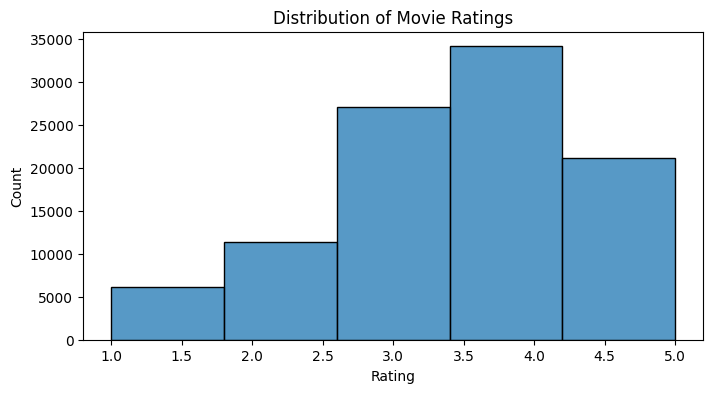

In [10]:
# Rating Distribution

plt.figure(figsize=(8, 4))
sns.histplot(df['rating'], bins=5, kde=False) # bins = 5 for the 5 possible ratings (1–5).
plt.title('Distribution of Movie Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()


<ipython-input-11-750ef150d51f>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=ratings_count.values, y=ratings_count.index, palette='viridis')


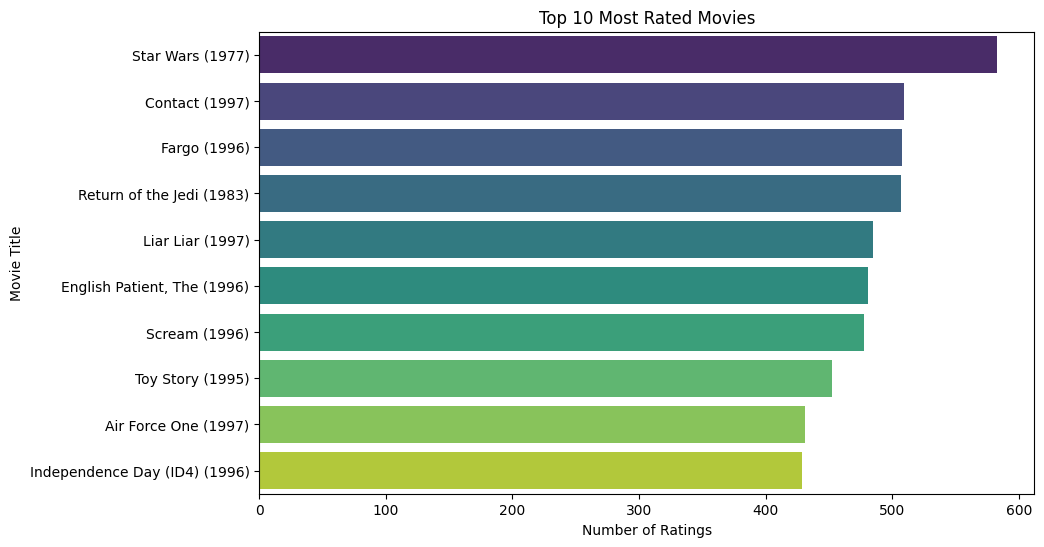

In [11]:
ratings_count = df['title'].value_counts().sort_values(ascending=False).head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=ratings_count.values, y=ratings_count.index, palette='viridis')
plt.title('Top 10 Most Rated Movies')
plt.xlabel('Number of Ratings')
plt.ylabel('Movie Title')
plt.show()


In [12]:
# Group by title and calculate average rating and rating count
movie_stats = df.groupby('title').agg({'rating': ['mean', 'count']})
# Flatten the MultiIndex columns
movie_stats.columns = ['average_rating', 'rating_count']

min_ratings = 100

popular_movies = movie_stats[movie_stats['rating_count'] >= min_ratings]

# Get the top 10 movies by average rating
top_movies = popular_movies.sort_values('average_rating', ascending=False).head(10)

<ipython-input-13-1e3ab6551f15>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=top_movies['average_rating'].values, y=top_movies.index, palette=colors)


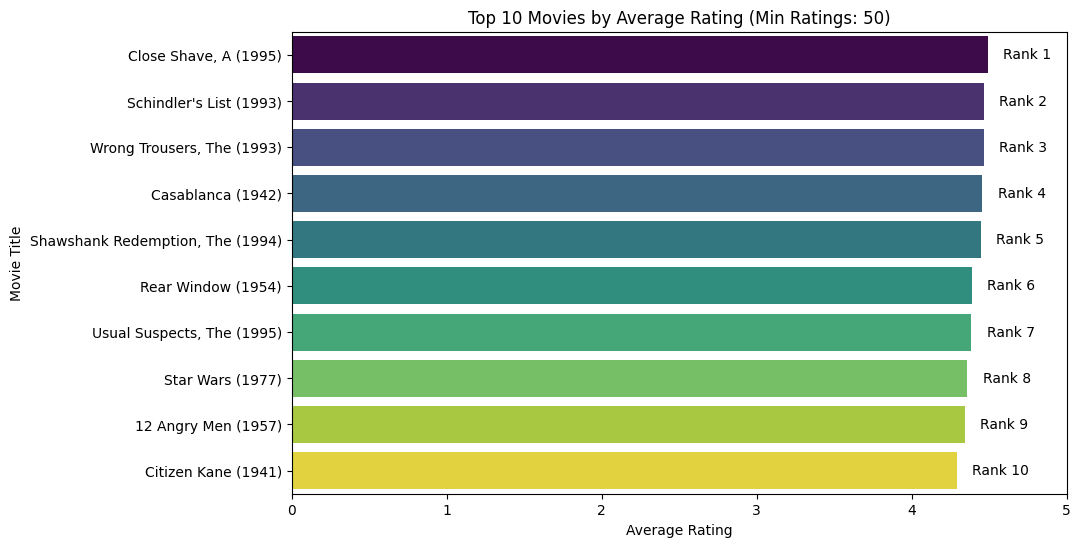

In [13]:
import matplotlib.cm as cm

# Generate a list of colors from the viridis colormap for the number of movies
n_movies = len(top_movies)
colors = cm.viridis(np.linspace(0, 1, n_movies))
# Convert the RGBA values to hex strings for use in Seaborn
colors = [cm.colors.rgb2hex(c) for c in colors]

plt.figure(figsize=(10, 6))
# Create a bar plot with our custom sequential color palette
ax = sns.barplot(x=top_movies['average_rating'].values, y=top_movies.index, palette=colors)

plt.title("Top 10 Movies by Average Rating (Min Ratings: 50)")
plt.xlabel("Average Rating")
plt.ylabel("Movie Title")
plt.xlim(0, 5)  # Ratings range from 1 to 5

# Annotate each bar with its rank (natural order)
for i, rating in enumerate(top_movies['average_rating'].values):
    # The highest-rated movie (first in the sorted order) gets Rank 1, etc.
    ax.text(rating + 0.1, i, f"Rank {i+1}", color='black', va="center", fontsize=10)

plt.show()

### Timestamp Analysis

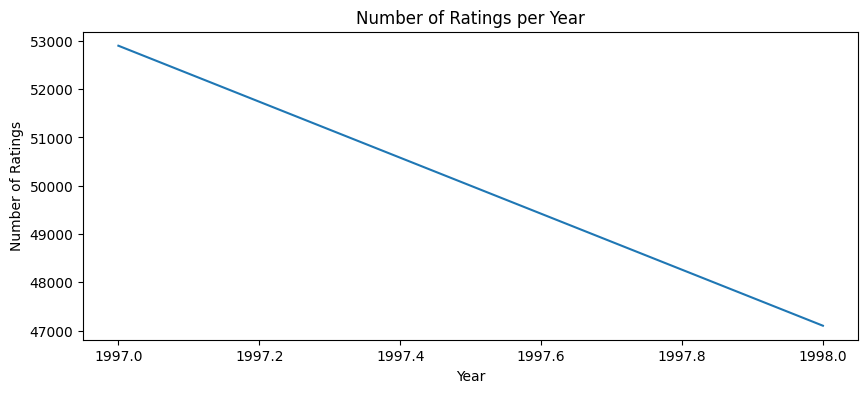

In [14]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['year'] = df['timestamp'].dt.year
ratings_per_year = df.groupby('year')['rating'].count()
plt.figure(figsize=(10, 4))
sns.lineplot(x=ratings_per_year.index, y=ratings_per_year.values)
plt.title('Number of Ratings per Year')
plt.xlabel('Year')
plt.ylabel('Number of Ratings')
plt.show()


# User-Based Collaborative Filtering with k-Nearest Neighbors

> * Find neighbors using knn.kneighbors().
* Gather each neighbor’s top-rated movies.
* Exclude movies the current user has already seen.
* Return a few unseen recommendations




### Create a user-movie matrix where rows represent users, columns represent movies, & values are the user's rating for that movie & initialize and train the k-NN model using cosine similarity

In [15]:
# Split the full DataFrame into training and test sets
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
print("Training ratings:", len(df_train))
print("Test ratings:", len(df_test))

# Create the filtered user-movie matrix for training data only
def create_filtered_user_movie_matrix(df, min_movie_ratings=5, min_user_ratings=5):
    """
    Create a user-movie matrix and filter out movies and users with very few ratings.
    """
    matrix = df.pivot_table(index="userId", columns="title", values="rating")
    # Filter movies with fewer than min_movie_ratings
    movie_rating_counts = df.groupby("title")["rating"].count()
    movies_to_keep = movie_rating_counts[movie_rating_counts >= min_movie_ratings].index
    matrix = matrix.loc[:, matrix.columns.isin(movies_to_keep)]
    # Filter users with fewer than min_user_ratings
    user_rating_counts = df.groupby("userId")["rating"].count()
    users_to_keep = user_rating_counts[user_rating_counts >= min_user_ratings].index
    matrix = matrix.loc[matrix.index.isin(users_to_keep)]
    return matrix.fillna(0)

# Build the user-movie matrix using training data
train_user_movie_matrix = create_filtered_user_movie_matrix(df_train)
print("Filtered training matrix shape:", train_user_movie_matrix.shape)

# Normalize the matrix by subtracting each user's mean rating (mean-centering)
normalized_matrix = train_user_movie_matrix.sub(train_user_movie_matrix.mean(axis=1), axis=0).fillna(0)

# Convert normalized matrix to a NumPy array for k-NN training
train_matrix_np = normalized_matrix.to_numpy()
print("Training matrix shape (normalized):", train_matrix_np.shape)

# Initialize and train the k-NN model using cosine similarity
knn = NearestNeighbors(metric='cosine', algorithm='brute')
knn.fit(train_matrix_np)

Training ratings: 80000
Test ratings: 20000
Filtered training matrix shape: (943, 1289)
Training matrix shape (normalized): (943, 1289)


NearestNeighbors(algorithm='brute', metric='cosine')

### Make a Recommendation Function


In [16]:
def recommend_movies(user_id, knn_model, normalized_matrix, raw_matrix,
                     num_neighbors=5, num_recommendations=5):
    """
    Recommend movies for a given user using a weighted k-NN approach.

    Parameters:
      - user_id: int, target user's ID.
      - knn_model: trained NearestNeighbors model (trained on normalized_matrix).
      - normalized_matrix: DataFrame with mean-centered ratings.
      - raw_matrix: DataFrame with original ratings (to filter out already rated movies).
      - num_neighbors: number of neighbors to consider.
      - num_recommendations: number of movie recommendations to return.

    Returns:
      - List of recommended movie titles.
    """
    # Ensure the user exists in the normalized matrix
    try:
        user_index = normalized_matrix.index.get_loc(user_id)
    except KeyError:
        return []

    # Get the target user's normalized rating vector (reshaped to 2D array)
    user_vector = normalized_matrix.iloc[user_index].to_numpy().reshape(1, -1)

    # Find nearest neighbors (adding 1 because the user is included in neighbors)
    distances, indices = knn_model.kneighbors(user_vector, n_neighbors=num_neighbors+1)
    neighbor_indices = indices[0][1:]  # Exclude the user itself
    # Convert distances to similarities (for cosine, similarity = 1 - distance)
    neighbor_similarities = 1 - distances[0][1:]

    # Accumulate weighted scores for each movie from neighbors
    recommended_scores = {}
    for sim, neighbor_idx in zip(neighbor_similarities, neighbor_indices):
        neighbor_ratings = normalized_matrix.iloc[neighbor_idx]
        for movie, rating in neighbor_ratings.items():
            if rating != 0:
                recommended_scores[movie] = recommended_scores.get(movie, 0) + sim * rating

    # Exclude movies the user has already rated (using raw ratings)
    already_rated = set(raw_matrix.loc[user_id][raw_matrix.loc[user_id] > 0].index)
    filtered_scores = {movie: score for movie, score in recommended_scores.items() if movie not in already_rated}

    # Sort the movies by aggregated weighted score (descending) and return top recommendations
    recommended_movies = sorted(filtered_scores, key=filtered_scores.get, reverse=True)[:num_recommendations]
    return recommended_movies




In [17]:
# Example: Generate recommendations for a specific user (e.g., user 10)
user_id = 10  # Change this as needed

# Use the recommendation function with:
# - The k-NN model (knn)
# - The normalized training matrix (normalized_matrix)
# - The raw (un-normalized) training matrix (train_user_movie_matrix) for filtering
recommendations = recommend_movies(user_id, knn, normalized_matrix, train_user_movie_matrix,
                                   num_neighbors=5, num_recommendations=5)
print("Recommendations for user", user_id, ":", recommendations)


Recommendations for user 10 : ['Casablanca (1942)', 'Cool Hand Luke (1967)', 'Boot, Das (1981)', 'Star Wars (1977)', 'Thin Man, The (1934)']


### Evaluate the Model

For evaluation, we'll compare the recommendations against the movies each user rated in the test set using the following metrics:

* Precision@k = Number of recommended movies that appear in the test set/Total # of recommended movies (k)
* Recall@k = For each user, we calculate the fraction of movies in the ground truth that appear in the recommendations.
* Mean Average Precision (MAP) = The MAP is then computed as the mean of the Average Precision scores across all evaluated users. The average_precision function goes through the ordered list of recommendations and, each time a relevant movie is encountered, computes the precision up to that point. These values are averaged over the total number of relevant items for that user.

In [18]:
def average_precision(recs, ground_truth):
    """
    Compute Average Precision for a single user's recommendations.

    Parameters:
      - recs: List of recommended movies (ordered by predicted relevance).
      - ground_truth: Set (or list) of movies that are relevant (e.g., movies the user rated in the test set).

    Returns:
      - Average Precision for the user.
    """
    if not ground_truth:
        return 0.0  # Avoid division by zero if there are no relevant items

    hit_count = 0
    precision_sum = 0.0
    for i, movie in enumerate(recs, start=1):
        if movie in ground_truth:
            hit_count += 1
            precision_sum += hit_count / i
    # Average over the total number of relevant items (ground_truth)
    return precision_sum / len(ground_truth)


In [19]:
k = 5  # Number of recommendations per user
precision_scores = []
recall_scores = []
average_precision_scores = []

# Identify users that are common to both training and test sets
common_users = set(df_test['userId']).intersection(train_user_movie_matrix.index)

for user in common_users:
    # Ground truth: movies that the user rated in the test set
    ground_truth = set(df_test[df_test['userId'] == user]['title'])

    # Get recommendations for the user from the training-based model
    recs = recommend_movies(user, knn, normalized_matrix, train_user_movie_matrix,
                            num_neighbors=5, num_recommendations=k)

    if recs:
        # Precision@k: fraction of recommended movies that are in the ground truth
        precision = len(set(recs) & ground_truth) / len(recs)
        precision_scores.append(precision)

        # Recall@k: fraction of the ground truth movies that are recommended
        recall = len(set(recs) & ground_truth) / len(ground_truth) if ground_truth else 0
        recall_scores.append(recall)

        # Compute Average Precision for this user
        ap = average_precision(recs, ground_truth)
        average_precision_scores.append(ap)

# Compute average metrics across users
if precision_scores:
    avg_precision = np.mean(precision_scores)
    avg_recall = np.mean(recall_scores)
    MAP = np.mean(average_precision_scores)

    print("Average Precision@{}: {:.2f}".format(k, avg_precision))
    print("Average Recall@{}: {:.2f}".format(k, avg_recall))
    print("Mean Average Precision (MAP): {:.2f}".format(MAP))
else:
    print("No common users for evaluation.")


Average Precision@5: 0.32
Average Recall@5: 0.10
Mean Average Precision (MAP): 0.07


In [23]:
# Experiment with a range of neighbor values
for num_neighbors in [5, 10, 15]:
    precision_list = []
    recall_list = []
    map_list = []
    for user in common_users:
        ground_truth = set(df_test[df_test['userId'] == user]['title'])
        recs = recommend_movies(user, knn, normalized_matrix, train_user_movie_matrix,
                                num_neighbors=num_neighbors, num_recommendations=k)
        if recs:
            precision = len(set(recs) & ground_truth) / len(recs)
            recall = len(set(recs) & ground_truth) / len(ground_truth) if ground_truth else 0
            ap = average_precision(recs, ground_truth)
            precision_list.append(precision)
            recall_list.append(recall)
            map_list.append(ap)
    print(f"Neighbors: {num_neighbors}")
    print("Avg Precision@{}: {:.2f}".format(k, np.mean(precision_list)))
    print("Avg Recall@{}: {:.2f}".format(k, np.mean(recall_list)))
    print("MAP: {:.2f}".format(np.mean(map_list)))


Neighbors: 5
Avg Precision@5: 0.32
Avg Recall@5: 0.10
MAP: 0.07
Neighbors: 10
Avg Precision@5: 0.35
Avg Recall@5: 0.12
MAP: 0.08
Neighbors: 15
Avg Precision@5: 0.37
Avg Recall@5: 0.12
MAP: 0.09


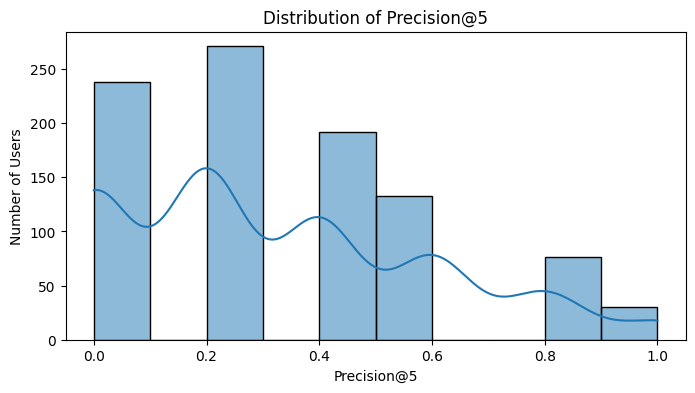

In [20]:
# Visualize Precision Distribution:

plt.figure(figsize=(8, 4))
sns.histplot(precision_scores, bins=10, kde=True)
plt.title("Distribution of Precision@{}".format(k))
plt.xlabel("Precision@{}".format(k))
plt.ylabel("Number of Users")
plt.show()


# Optimized k‑NN model using an approximate nearest neighbor library (Annoy)

In [24]:
# Install Annoy (if not already installed)
# !pip install annoy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 8.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for annoy: filename=annoy-1.17.3-cp311-cp311-linux_x86_64.whl size=553117 sha256=4e71fac17fa85f111facd3f19873ecd88f5cacef2037b0a4395607f2966e557f
  Stored in directory: /root/.cache/pip/wheels/33/e5/58/0a3e34b92bedf09b4c57e37a63ff395ade6f6c1099ba59877c
Successfully built annoy


In [25]:
from annoy import AnnoyIndex

# Determine the number of dimensions (number of movies in the matrix)
dims = normalized_matrix.shape[1]

# Initialize the Annoy index with the angular (cosine-like) metric
annoy_index = AnnoyIndex(dims, 'angular')

# Convert the normalized matrix to a NumPy array
normalized_array = normalized_matrix.to_numpy()
num_users = normalized_array.shape[0]

# Add each user's rating vector to the Annoy index
for i in range(num_users):
    annoy_index.add_item(i, normalized_array[i])

# Build the Annoy index (tuning the number of trees can affect both speed and accuracy)
n_trees = 10  # Try increasing this value if you need better accuracy at the cost of slower indexing
annoy_index.build(n_trees)

print("Annoy index built with {} items and {} dimensions.".format(num_users, dims))


Annoy index built with 943 items and 1289 dimensions.


## Define the Recommendation Function Using Annoy

In [30]:
def recommend_movies_annoy(user_id, annoy_index, normalized_matrix, raw_matrix,
                           num_neighbors=5, num_recommendations=5):
    """
    Recommend movies for a given user using an Annoy-based k-NN model.

    Parameters:
      - user_id: int, the target user's ID.
      - annoy_index: an AnnoyIndex built on the normalized user-movie matrix.
      - normalized_matrix: DataFrame with mean-centered (normalized) ratings.
      - raw_matrix: DataFrame with original ratings (to filter out already rated movies).
      - num_neighbors: number of nearest neighbors to consider.
      - num_recommendations: number of movie recommendations to return.

    Returns:
      - A list of recommended movie titles.
    """
    try:
        user_index = normalized_matrix.index.get_loc(user_id)
    except KeyError:
        return []

    # Get the target user's normalized vector
    user_vector = normalized_matrix.iloc[user_index].to_numpy()

    # Retrieve nearest neighbors using Annoy
    # Note: Annoy includes the query item itself, so we ask for one extra neighbor.
    neighbor_indices, distances = annoy_index.get_nns_by_vector(user_vector, num_neighbors+1, include_distances=True)

    # Exclude the user itself if present
    if neighbor_indices[0] == user_index:
        neighbor_indices = neighbor_indices[1:]
        distances = distances[1:]
    else:
        neighbor_indices = neighbor_indices[:-1]
        distances = distances[:-1]

    # Aggregate weighted scores from neighbors
    recommended_scores = {}
    for neighbor_idx, dist in zip(neighbor_indices, distances):
        # Convert distance to a similarity score.
        # One simple way: similarity = 1 / (1 + distance)
        similarity = 1 / (1 + dist)
        neighbor_ratings = normalized_matrix.iloc[neighbor_idx]
        # For each movie that the neighbor has rated (non-zero normalized rating)
        for movie, rating in neighbor_ratings.items():
            if rating != 0:
                recommended_scores[movie] = recommended_scores.get(movie, 0) + similarity * rating

    # Exclude movies that the user has already rated (using raw ratings)
    already_rated = set(raw_matrix.loc[user_id][raw_matrix.loc[user_id] > 0].index)
    filtered_scores = {movie: score for movie, score in recommended_scores.items() if movie not in already_rated}

    # Sort movies by the aggregated weighted score and select the top recommendations
    recommended_movies = sorted(filtered_scores, key=filtered_scores.get, reverse=True)[:num_recommendations]
    return recommended_movies

# Example usage:
user_id = 10  # Change this to test with a different user ID
annoy_recs = recommend_movies_annoy(user_id, annoy_index, normalized_matrix, train_user_movie_matrix,
                                    num_neighbors=10, num_recommendations=5)
print("Annoy-based recommendations for user", user_id, ":", annoy_recs)

print("original KNN model output for user 10:")
print("['Casablanca (1942)', 'Cool Hand Luke (1967)', 'Boot, Das (1981)', 'Star Wars (1977)', 'Thin Man, The (1934)']")



Annoy-based recommendations for user 10 : ['Star Wars (1977)', 'Cool Hand Luke (1967)', 'Annie Hall (1977)', 'Boot, Das (1981)', 'To Kill a Mockingbird (1962)']
original KNN model output for user 10:
['Casablanca (1942)', 'Cool Hand Luke (1967)', 'Boot, Das (1981)', 'Star Wars (1977)', 'Thin Man, The (1934)']


### Evaluate Annoy-based model

In [32]:
k = 5  # Number of recommendations per user for evaluation
precision_scores = []
recall_scores = []
average_precision_scores = []

# Identify users that are common to both training and test sets
common_users = set(df_test['userId']).intersection(train_user_movie_matrix.index)

def average_precision(recs, ground_truth):
    if not ground_truth:
        return 0.0
    hit_count = 0
    precision_sum = 0.0
    for i, movie in enumerate(recs, start=1):
        if movie in ground_truth:
            hit_count += 1
            precision_sum += hit_count / i
    return precision_sum / len(ground_truth)

for user in common_users:
    ground_truth = set(df_test[df_test['userId'] == user]['title'])
    recs = recommend_movies_annoy(user, annoy_index, normalized_matrix, train_user_movie_matrix,
                                  num_neighbors=10, num_recommendations=k)
    if recs:
        precision = len(set(recs) & ground_truth) / len(recs)
        recall = len(set(recs) & ground_truth) / len(ground_truth) if ground_truth else 0
        ap = average_precision(recs, ground_truth)
        precision_scores.append(precision)
        recall_scores.append(recall)
        average_precision_scores.append(ap)

if precision_scores:
    avg_precision = np.mean(precision_scores)
    avg_recall = np.mean(recall_scores)
    MAP = np.mean(average_precision_scores)
    print("Annoy-based model - Average Precision@{}: {:.2f}".format(k, avg_precision))
    print("Annoy-based model - Average Recall@{}: {:.2f}".format(k, avg_recall))
    print("Annoy-based model - MAP: {:.2f}".format(MAP))
else:
    print("No common users for evaluation.")


Annoy-based model - Average Precision@5: 0.35
Annoy-based model - Average Recall@5: 0.12
Annoy-based model - MAP: 0.08


# Matrix Factorization - SVD

In [22]:
from sklearn.decomposition import TruncatedSVD

# svd = TruncatedSVD(n_components=50, random_state=42)
# matrix_svd = svd.fit_transform(user_movie_matrix)


# Build Out Interactive UI

In [ ]:
import ipywidgets as widgets
from IPython.display import display, clear_output

def get_recommendations(b):
    try:
        user_id = int(user_id_widget.value)
    except ValueError:
        with output:
            clear_output()
            print("Please enter a valid numeric User ID.")
        return

    # Get recommendations for the given user_id (using your pre-trained knn and train_user_movie_matrix)
    recs = recommend_movies(user_id, knn, train_user_movie_matrix, num_neighbors=5, num_recommendations=5)

    with output:
        clear_output()
        if recs:
            print("Recommendations for user", user_id, ":", recs)
        else:
            print("No recommendations available for user", user_id)


In [ ]:
# Widget for entering user ID
user_id_widget = widgets.Text(
    value="10",
    description="User ID:",
    placeholder="Enter a user ID"
)

# Button to get recommendations
button = widgets.Button(
    description="Get Recommendations",
    button_style="success"  # Optional: gives the button a green color
)

# Output area to display recommendations
output = widgets.Output()

# Link the button click event to the recommendation function
button.on_click(get_recommendations)


In [ ]:
display(user_id_widget, button, output)